In [1]:

from __future__ import annotations
import os
import sys
import numpy as np
sys.path.append('/home/gpuvmadm/PyTomography/src')
import pytomography
from pytomography.metadata import PSFMeta
from pytomography.mappings import MapNet
from pytomography.utils import pad_object, pad_image, unpad_object, unpad_image, rotate_detector_z
from pytomography.metadata import ObjectMeta, ImageMeta
from pytomography.projections import ForwardProjectionNet, BackProjectionNet
from pytomography.algorithms import OSEMOSL
from pytomography.priors import RelativeDifferencePrior
from pytomography.mappings import PETAttenuationNet, PETPSFNet
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
from matplotlib import colors
import torch
from scipy.ndimage import map_coordinates
from scipy.interpolate import interpn
from scipy.ndimage import zoom
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pytomography.device = device

/tmp/ipykernel_3745/3448874680.py:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [2]:
path = '/home/gpuvmadm/PyTomography/test_files' 

In [3]:
GT = np.fromfile(os.path.join(path,'body2_F18.bin'), dtype=np.float32)
CT = np.fromfile(os.path.join(path,'body_atn_511keV.bin'), dtype=np.float32)

In [4]:
GT = GT.reshape((751,512,512))
CT = CT.reshape((751,512,512))

In [5]:
GT = zoom(GT, (384/751, 256/512, 256/512), order=1)
CT = zoom(CT, (384/751, 256/512, 256/512), order=1)

In [6]:
GT = np.transpose(GT, (2,1,0))
CT = np.transpose(CT, (2,1,0))

In [7]:
GT = torch.tensor(GT).unsqueeze(dim=0)
CT = torch.tensor(CT).unsqueeze(dim=0)

In [8]:
object_meta = ObjectMeta(dr=(0.15,0.15,0.767), shape=[256,256,384])
image_meta = ImageMeta(object_meta, angles=np.linspace(0,180,574, endpoint=False), radii=44.3*np.ones(574))

In [9]:
dx, dy, dz = object_meta.dr
scale_factor = dx*dy*dz * 1.76 #1.76 cps / Bq
GT = GT * scale_factor

In [10]:
def kernel_noncol(x,r,R, delta=1e-8):
    if r**2<R**2:
        sigma = torch.sqrt(R**2 - r**2)/4 * np.pi / 180
    else:
        sigma = torch.zeros(r.shape) + delta
    result = torch.exp(-x**2/sigma**2 / 2)
    return result / (torch.sum(result)+delta)

def kernel_penetration(x,r,R,mu=0.87, delta=1e-8):
    result = torch.exp(-torch.abs(mu*x / ((r/R)*torch.sqrt(1-(r/R)**2) + delta)))
    if r>=0:
        result*= x <= 0
    else:
        result*= x >= 0
    return result / (torch.sum(result)+delta)

def kernel_scattering(x,r,R,scatter_fact=0.327, delta=1e-8):
    sigma = scatter_fact * torch.sqrt(1-(r/R)**2) / (2 * np.sqrt(2*np.log(2))) # fwhm -> sigma
    result = torch.exp(-x**2/sigma**2 / 2)
    return result / (torch.sum(result)+delta)

In [11]:
kernels = [kernel_noncol, kernel_penetration, lambda x, r, R: kernel_penetration(2*x, r, R), kernel_scattering]

In [12]:
ctnet = PETAttenuationNet(CT = CT, device=device)
psfnet = PETPSFNet(kernels, device=device)
fp_net = ForwardProjectionNet(obj2obj_nets=[],
                              im2im_nets=[ctnet,psfnet],
                              object_meta=object_meta,
                              image_meta=image_meta)
bp_net = BackProjectionNet(obj2obj_nets=[],
                           im2im_nets=[ctnet,psfnet],
                           object_meta=object_meta,
                           image_meta=image_meta)

/data/anaconda/envs/torch/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


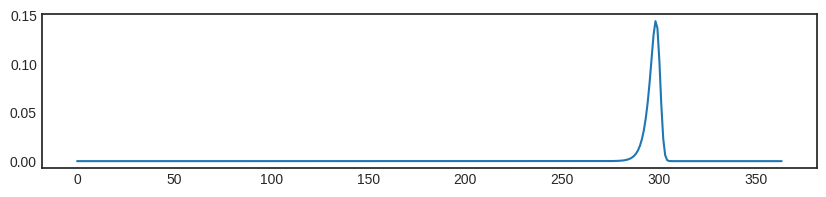

In [13]:
plt.figure(figsize=(10,2))
plt.plot(psfnet.PSF_matrix[0][0][0][300].cpu())
plt.show()

In [14]:
projections_analytic = fp_net(torch.poisson(GT))

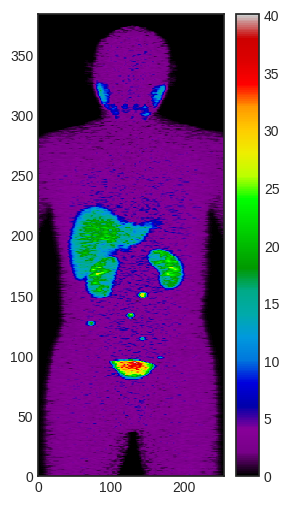

In [15]:
plt.figure(figsize=(3,6))
plt.pcolormesh(projections_analytic[0,0].cpu().T, cmap='nipy_spectral')
plt.colorbar()

Make a reconstruction network

In [16]:
rdp = RelativeDifferencePrior(beta=20, gamma=2)

In [17]:
osem_net = OSEMOSL(image = projections_analytic,
                   forward_projection_net=fp_net,
                   back_projection_net=bp_net)
reconstructed_object = osem_net(n_iters=2, n_subsets=7)

In [18]:
osem_net = OSEMOSL(image = projections_analytic,
                   forward_projection_net=fp_net,
                   back_projection_net=bp_net,
                   prior=rdp)
reconstructed_object_rdp = osem_net(n_iters=10, n_subsets=7)

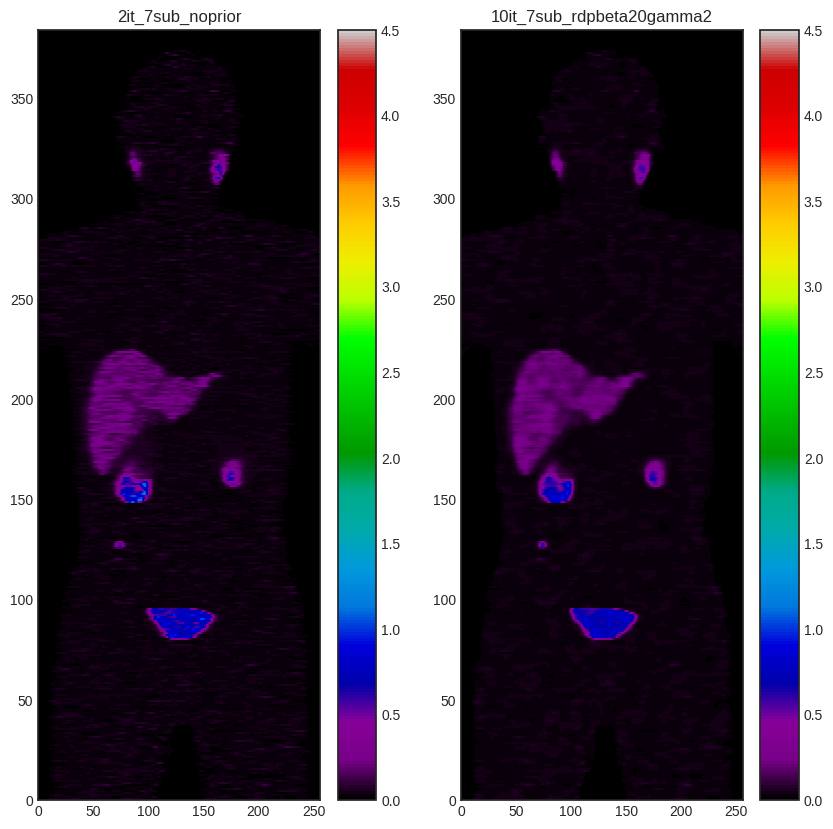

In [19]:
plt.subplots(1,2,figsize=(10,10))
plt.subplot(121)
plt.title('2it_7sub_noprior')
plt.pcolormesh(reconstructed_object[0][:,128].cpu().T, cmap='nipy_spectral', vmax=4.5)
plt.colorbar()
plt.subplot(122)
plt.title('10it_7sub_rdpbeta20gamma2')
plt.pcolormesh(reconstructed_object_rdp[0][:,128].cpu().T, cmap='nipy_spectral', vmax=4.5)
plt.colorbar()

In [23]:
from torch.nn.functional import pad

In [42]:
x = torch.arange(125).reshape(1,5,5,5)
x = pad(x, [1,1,1,1,1,1])
x = torch.roll(x, shifts=(-1,1,1), dims=(1,2,3))
x = x[:,1:-1,1:-1,1:-1]

In [43]:
x

tensor([[[[  0,   0,   0,   0,   0],
          [  0,  25,  26,  27,  28],
          [  0,  30,  31,  32,  33],
          [  0,  35,  36,  37,  38],
          [  0,  40,  41,  42,  43]],

         [[  0,   0,   0,   0,   0],
          [  0,  50,  51,  52,  53],
          [  0,  55,  56,  57,  58],
          [  0,  60,  61,  62,  63],
          [  0,  65,  66,  67,  68]],

         [[  0,   0,   0,   0,   0],
          [  0,  75,  76,  77,  78],
          [  0,  80,  81,  82,  83],
          [  0,  85,  86,  87,  88],
          [  0,  90,  91,  92,  93]],

         [[  0,   0,   0,   0,   0],
          [  0, 100, 101, 102, 103],
          [  0, 105, 106, 107, 108],
          [  0, 110, 111, 112, 113],
          [  0, 115, 116, 117, 118]],

         [[  0,   0,   0,   0,   0],
          [  0,   0,   0,   0,   0],
          [  0,   0,   0,   0,   0],
          [  0,   0,   0,   0,   0],
          [  0,   0,   0,   0,   0]]]])